The problem addressed in this project is the classification of musical tracks into different levels of energy using a classification model. Specifically, it aims to determine whether a track is not energetic, moderately energetic, or energetic. The solution to this problem is based on data regarding various attributes of the track, such as key, loudness, speechiness, acousticness, instrumentalness, valence, danceability, tempo, and also the musical genre to which the track can be categorized.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import csv  
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keys import CLIENT_ID, CLIENT_SECRET

<h4>Collecting data</h4>

To acquire data using Spotify API, the following methods will be needed.

In [2]:
def acquire_data(playlist_link, filename):
    #authorization and creation of spotify object:
    client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager, requests_timeout=10,retries=10)

    playlist_URI = playlist_link.split("/")[-1].split("?")[0]
    tracks = [x for x in get_all_tracks(playlist_URI, sp)]  #collecting all songs from given playlist

    with open(filename, 'a', encoding='UTF8', newline='') as f:

        fieldnames=['key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                        'valence', 'genre', 'energy', 'danceability' ,'tempo']
        
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

        for track in tracks:
            try:
                track_uri = track["track"]["uri"]
                
                artist_uri = track["track"]["artists"][0]["uri"]
                artist_info = sp.artist(artist_uri)
                artist_genres = artist_info["genres"]

                audio_features = sp.audio_features(track_uri)[0]
                #saving audio features and genre of each track
                row=create_row(audio_features, artist_genres[0])  #we'll take the primary genre of the artist
                writer.writerow(row)

            except (IndexError, TypeError): #tracks with missing data will be skipped
                pass

In [3]:
def get_all_tracks(playlist_URI, sp):
    results = sp.playlist_tracks(playlist_URI)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [4]:
def create_row(audio_features,genre):
    row={}
    row['key'] = audio_features['key']
    row['loudness'] = audio_features['loudness']
    row['speechiness'] = audio_features['speechiness']
    row['acousticness'] = audio_features['acousticness']
    row['instrumentalness'] = audio_features['instrumentalness']
    row['valence'] = audio_features['valence']
    row['energy'] = audio_features['energy']
    row['danceability'] = audio_features['danceability']
    row['tempo'] = audio_features['tempo']
    row['genre'] = genre
    return row

Now we can collect the tracks' data from the specified playlist and save it to a csv file. 
Here's an example, but as this may take a while to acquire enough data, there's a full file attached.

In [5]:
#playlist_link = "https://open.spotify.com/playlist/1G8IpkZKobrIlXcVPoSIuf?si=ynGH2ZHIS7Gg1nlpDyBF-g"
filename = "tracks_data.csv"

#acquire_data(playlist_link, filename)

<h3>Data analysis</h3>

Let's read the data from our file first.

In [6]:
data = pd.read_csv(filename) 
data.head()

,key,loudness,speechiness,acousticness,instrumentalness,valence,genre,energy,danceability,tempo
0,0,-6.839,0.0321,0.731000,0.000000,0.557,rock,0.721,0.482,95.263
1,1,-9.027,0.0495,0.000012,0.016200,0.767,rock,0.863,0.485,116.835
2,4,-14.162,0.0675,0.290000,0.000106,0.175,rock,0.457,0.364,163.219
3,1,-10.934,0.0388,0.082200,0.000025,0.331,pop,0.413,0.398,133.574
4,10,-10.851,0.0915,0.735000,0.000062,0.968,rhythmic,0.756,0.518,166.429


Let's try some visualizations.
Here are methods that will be used to present the relationship between energy and a given feature on a scatter plot.

In [7]:
def visualize_scatter(data, factor):
    plt.figure()
    sns.scatterplot(
        x=factor,
        y='energy',
        data=data,
        size=factor,
        sizes=(15,15),
        legend=False
    )
    plt.show()

def visualize_reg(data, factor):
    plt.figure()
    sns.regplot(
        x=factor,
        y='energy',
        data=data,
        scatter_kws={'s':2},
        line_kws={'color':'red'}
    )
    plt.show()

Loudness is strongly correlated with energy - the louder and more boisterous a track seems, the higher its energy level. As we can observe on the chart below, the energy increases with loudness.

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


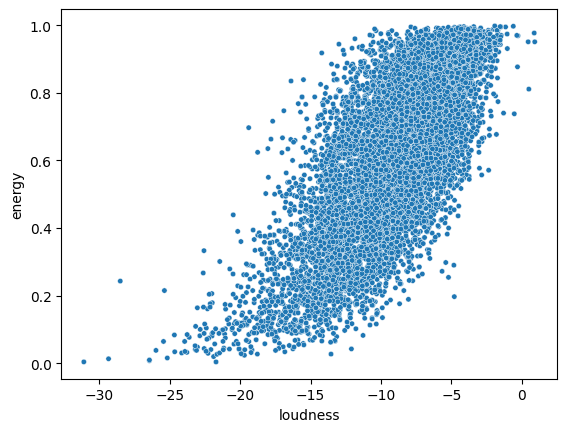

In [8]:
visualize_scatter(data,"loudness")

The relationship between speeechiness and energy appears to be small. The presence of spoken words in a track may give the impression of intensity, but this is only slightly noticeable in the chart below. We'll have another look at speechiness later.

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


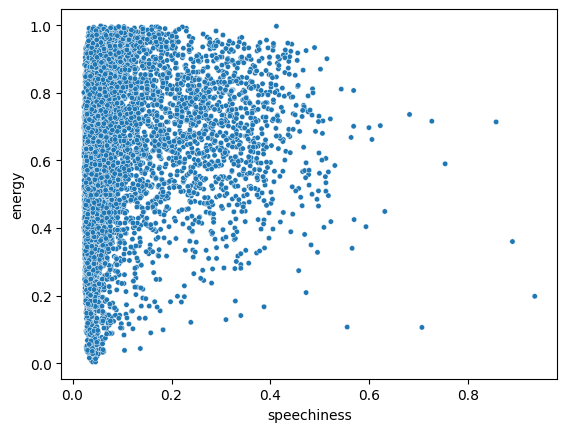

In [9]:
visualize_scatter(data,"speechiness")

As acousticness increases, the energy of the track decreases - the track seems quieter, calmer.

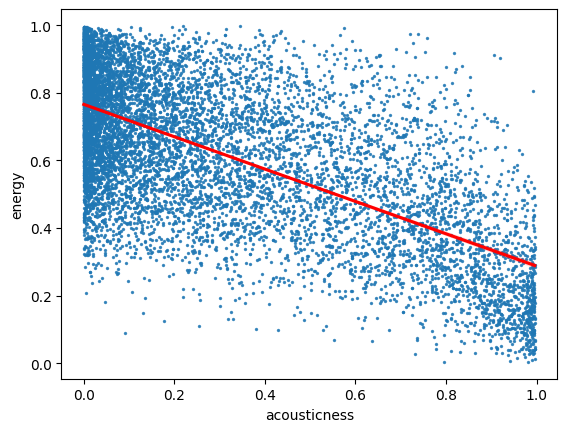

In [10]:
visualize_reg(data,"acousticness")

The relationship between energy and valence is not that clear. However, looking at the chart, it can be said that tracks that "sound happier" (have higher valence) are much less likely to belong to "not energetic" category.

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


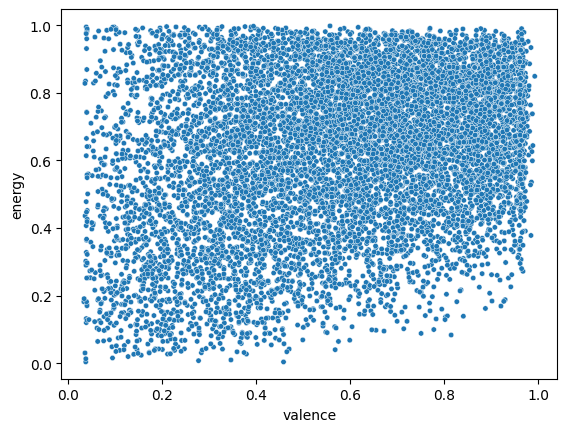

In [11]:
visualize_scatter(data, "valence")

There is no noticeable relationship between instrumentalness and energy on the chart below. It seems that both instrumental tracks and those with vocals can be equally energetic.

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


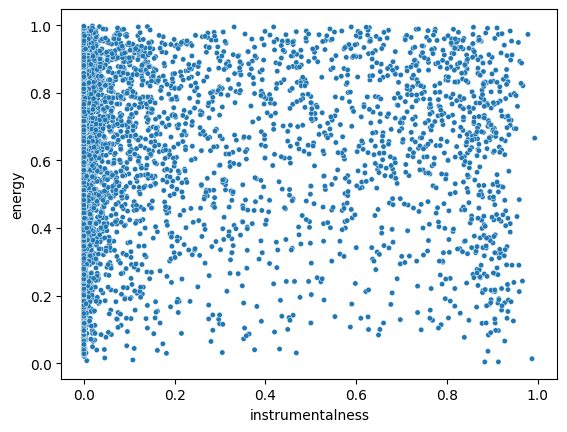

In [12]:
visualize_scatter(data,"instrumentalness")

The relationship between danceability and energy is also not very evident. The only observation that comes to mind when looking at the chart below is that songs with high danceability mostly have higher energy levels.

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


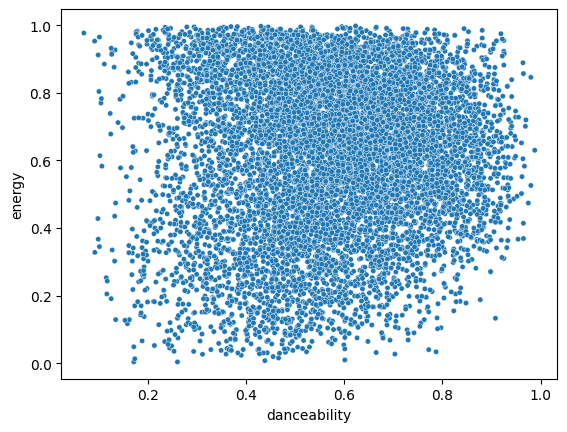

In [13]:
visualize_scatter(data, "danceability")

Tempo also isn't distinctly correlated to energy.

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


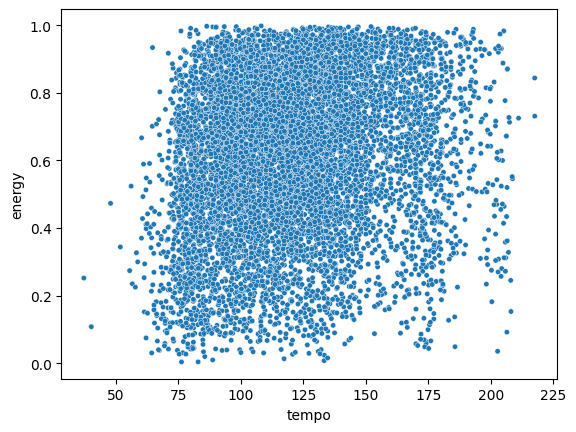

In [14]:
visualize_scatter(data, "tempo")

<h4>Data preprocessing</h4>
10,000 rows of data were obtained, each containing the necessary set of song information. It is necessary to appropriately process part of the data.

Since Spotify distinguishes over five thousand musical genres, it is necessary to generalize the genres in the dataset in order to make the proper analysis possible. After analyzing the problem, I decided to devide genres into four groups: rock, hip hop, rhythmic music and pop.
Thenhe genre, as a non-numeric value, is represented using so-called dummy columns.

In [15]:
def generalized_genre(genre):
    rock_music = ["rock","grunge","indie","wave","metal","beatlesque","mod revival","punk"]
    hip_hop = ["hip hop", "rap"]
    rhythmic_music = ["soul", "r&b", "funk", "reggae", "motown","blues","doo-wop","bebop", "jazz","rhythmic"]
    for x in rock_music:
        if x in genre:
            return "rock"
    for x in hip_hop:
        if x in genre:
            return "hip hop"
    for x in rhythmic_music:
        if x in genre:
            return "rhythmic"
    return "pop"


In [16]:
data['genre'] = data['genre'].apply(generalized_genre)
data.head()

,key,loudness,speechiness,acousticness,instrumentalness,valence,genre,energy,danceability,tempo
0,0,-6.839,0.0321,0.731000,0.000000,0.557,rock,0.721,0.482,95.263
1,1,-9.027,0.0495,0.000012,0.016200,0.767,rock,0.863,0.485,116.835
2,4,-14.162,0.0675,0.290000,0.000106,0.175,rock,0.457,0.364,163.219
3,1,-10.934,0.0388,0.082200,0.000025,0.331,pop,0.413,0.398,133.574
4,10,-10.851,0.0915,0.735000,0.000062,0.968,rhythmic,0.756,0.518,166.429


Now let's try another visualization. This method will be used to present energy levels of tracks with track's genre distinguishable through color.

In [17]:
def scatter_colored_by_genre(data):   
    
    sample = data[:5000]  #using only a part of data to make the plot clearer
    groups = sample.groupby('genre')
    sample['ind'] = range(1, len(sample) + 1) 
    
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group['ind'], group['energy'], marker='o', linestyle='', ms=4, label=name)
    ax.set_xlabel('song')
    ax.set_ylabel('energy')
    ax.legend()
    plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_1420\3889752281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['ind'] = range(1, len(sample) + 1)


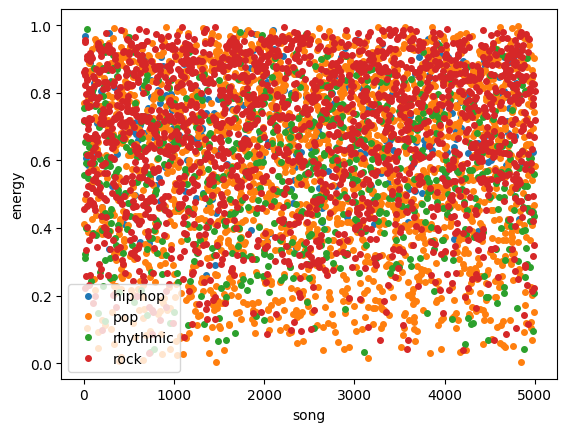

In [18]:
scatter_colored_by_genre(data)

Upon closer examination, it can be observed that the red dots representing rock songs are clustered at the top - they mostly have high levels of energy. The same can be said about hip-hop. Pop songs seem to be almost evenly spread across the whole chart, whereas rhythmic music is concentrated mostly in the middle.

We are also going to categorize tracks' energy values. Energy level ranges from 0 to 1. Here, tracks with a rating below 0.4 are considered not energetic, those between 0.4 and 0.7 are considered moderately energetic, and the remaining ones are considered energetic.

In [19]:
def categorize_energy(data):
    bins = (-1,0.4, 0.7, 1)
    names = ['not energetic','medium','energetic']
    new_col = pd.cut(data.energy,bins,labels=names)
    data.energy = new_col
    return data

In [20]:
data=categorize_energy(data) 
data.head()

,key,loudness,speechiness,acousticness,instrumentalness,valence,genre,energy,danceability,tempo
0,0,-6.839,0.0321,0.731000,0.000000,0.557,rock,energetic,0.482,95.263
1,1,-9.027,0.0495,0.000012,0.016200,0.767,rock,energetic,0.485,116.835
2,4,-14.162,0.0675,0.290000,0.000106,0.175,rock,medium,0.364,163.219
3,1,-10.934,0.0388,0.082200,0.000025,0.331,pop,medium,0.398,133.574
4,10,-10.851,0.0915,0.735000,0.000062,0.968,rhythmic,energetic,0.518,166.429


We can now see percentage of energy groups in given genres.

In [21]:
def energy_group_percentage_for_genres(data): 
    for genre in ['rock','rhythmic','pop','hip hop']:
        ax = sns.histplot(x='genre', hue='energy', multiple="dodge", data=data[data.genre==genre], stat='percent')
        ax.set_ylabel('percentage')
        plt.show()

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

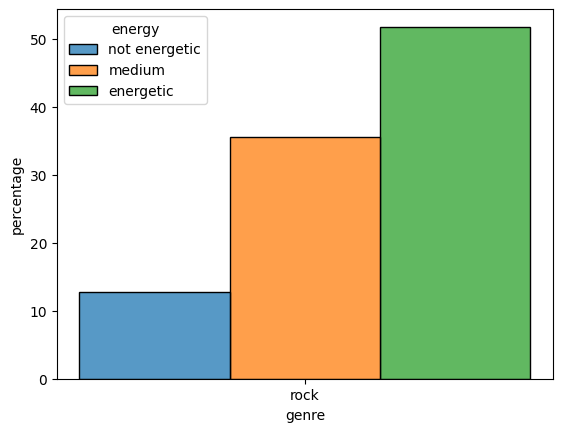

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

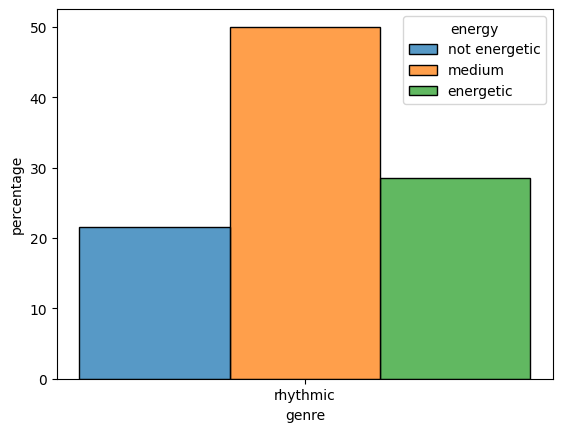

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

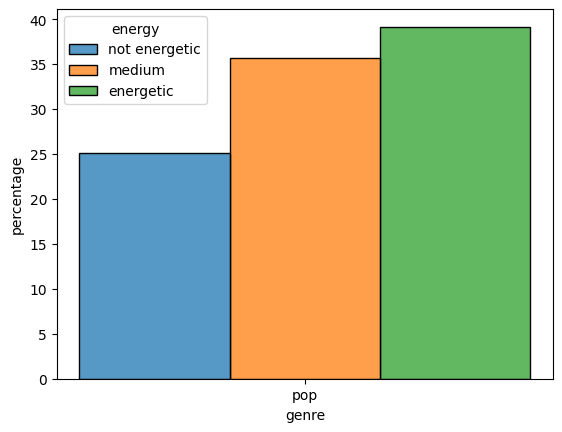

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert 

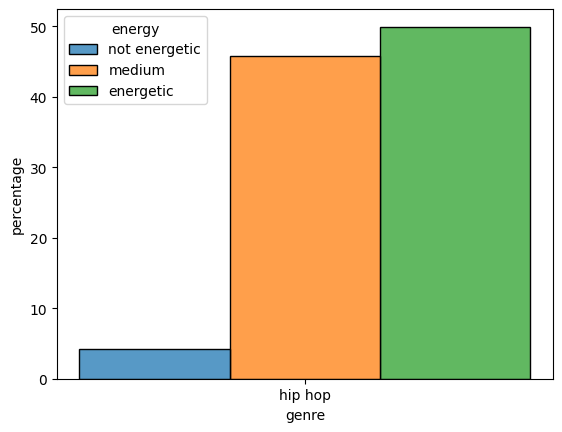

In [22]:
energy_group_percentage_for_genres(data)

We can see that indeed only slightly over 10% of rock songs and around 5% of hip-hop songs are not energetic. The energy categories in pop are distributed almost evenly, whereas the majority of rhythmic music is moderately energetic.

Finally, the genre, as a non-numeric value, will be represented with the use of dummy columns.

In [23]:
def categorize_genres(data):
    dummies = pd.get_dummies(data['genre'],drop_first=False)
    data.drop('genre', axis=1, inplace=True)
    data = pd.concat([data, dummies], axis=1)
    return data

In [24]:
data=categorize_genres(data) 
data.head()

,key,loudness,speechiness,acousticness,instrumentalness,valence,energy,danceability,tempo,hip hop,pop,rhythmic,rock
0,0,-6.839,0.0321,0.731000,0.000000,0.557,energetic,0.482,95.263,False,False,False,True
1,1,-9.027,0.0495,0.000012,0.016200,0.767,energetic,0.485,116.835,False,False,False,True
2,4,-14.162,0.0675,0.290000,0.000106,0.175,medium,0.364,163.219,False,False,False,True
3,1,-10.934,0.0388,0.082200,0.000025,0.331,medium,0.398,133.574,False,True,False,False
4,10,-10.851,0.0915,0.735000,0.000062,0.968,energetic,0.518,166.429,False,False,True,False


Let's look at average values of audio features for given energy groups.

In [25]:
def average_visualization(data, x, y): 
    result = data[[x,y]]
    result = data.groupby(x).mean()
    plt.bar(result.index, result[y])
    plt.ylabel(f"average {y}")
    plt.grid()
    plt.show()

When it comes to speechiness, this turns out to be a more suggestive visualization than a scatter plot.

C:\Users\HP\AppData\Local\Temp\ipykernel_1420\3148703955.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = data.groupby(x).mean()


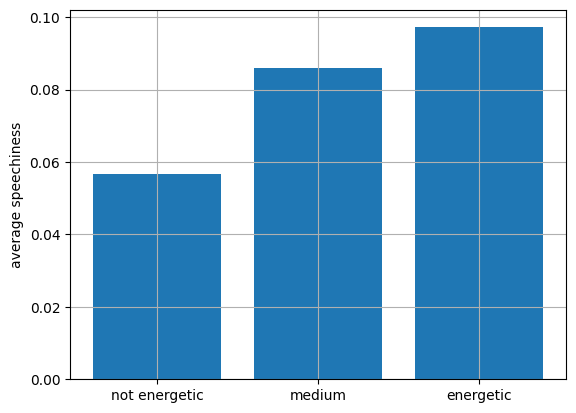

In [26]:
average_visualization(data,"energy","speechiness")

On average, not energetic tracks' valence is lower, while moderate and energetic tracks have higher values of valence.

C:\Users\HP\AppData\Local\Temp\ipykernel_1420\3148703955.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = data.groupby(x).mean()


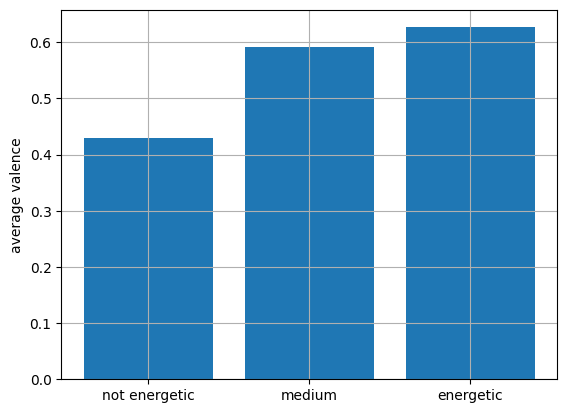

In [27]:
average_visualization(data, "energy", "valence")

For successive energy groups, the average tempo increases; however, there are no significant differences between them.

C:\Users\HP\AppData\Local\Temp\ipykernel_1420\3148703955.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = data.groupby(x).mean()


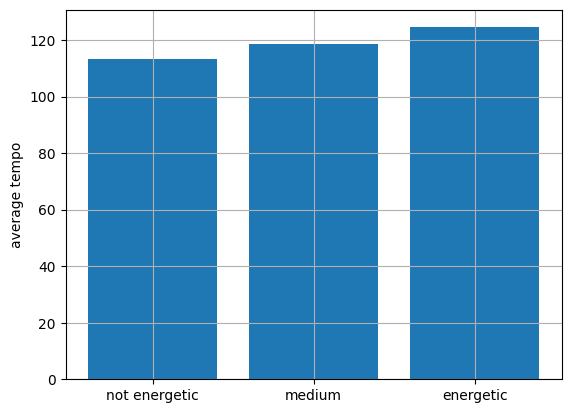

In [28]:
average_visualization(data, "energy", "tempo")

<h3>Data modeling</h3>
At the beginning, data read from the file is assigned to variables X and Y, where Y contains the column with energy data (target data), and X contains explanatory data, i.e., the remaining columns. The features should be scaled. 

In [30]:
def split_datasets(dataset):
    target = ['energy']
    prediction_cols = ['loudness','speechiness','acousticness','instrumentalness','valence','danceability','tempo',
                       'hip hop','pop','rhythmic','rock']
    return dataset[prediction_cols], dataset[target]

In [31]:
X,Y = split_datasets(data)
scaler = StandardScaler()
X = scaler.fit_transform(X.astype(float))         
Y = Y.values.ravel()

Then, the data is split into training and test sets in a 3:1 ratio.

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

When creating models, the selection of optimal parameters can be facilitated by the GridSearchCV object, which, by trying combinations of parameters, selects and returns a model with the parameters that achieved the best results.

In [33]:
def model_with_opt_parameters(model, parameters, X_train, Y_train):
    grid = GridSearchCV(model,parameters,refit = True, n_jobs=1)
    grid.fit(X_train,Y_train)      
    return grid.best_estimator_ 

Let's create the models - SVM, k-NN, decision tree, random forest, logistic regression. 

In [34]:
def logistic_regr(X_train, Y_train):
    log_reg = LogisticRegression()  
    params = {'solver':['liblinear','newton-cg', 'sag', 'saga', 'lbfgs'], 'C':[0.01,0.1,1.,10.]}  
    log_reg = model_with_opt_parameters(log_reg,params,X_train,Y_train) 
    return log_reg 

def svc(X_train, Y_train,):
    svc = SVC() 
    params =  {'C':[0.01,0.1,1.,10.],'gamma': [0.01, 0.1, 1., 10.]} 
    svc = model_with_opt_parameters(svc,params, X_train, Y_train)
    return svc

def random_forest(X_train,Y_train):
    random_forest = RandomForestClassifier()
    parameters = {'n_estimators': [10,30,50,100,150], 'max_features': ['log2', 'sqrt']}
    random_forest = model_with_opt_parameters(random_forest, parameters, X_train, Y_train)
    return random_forest

def knn(X_train, Y_train):
    knn = KNeighborsClassifier()
    params = {'n_neighbors':[5,10,15,25,35,50]}
    knn = model_with_opt_parameters(knn, params, X_train, Y_train)
    return knn

def decision_tree(X_train, Y_train):
    dtc = DecisionTreeClassifier()
    params = {'criterion' : ['gini', 'entropy', 'log_loss'], 'max_features': ['log2', 'sqrt']}
    dtc = model_with_opt_parameters(dtc,params,X_train,Y_train)
    return dtc

In [35]:
models = {'SVC':svc(X_train, Y_train), 'k-NN':knn(X_train, Y_train),
            'Random forest':random_forest(X_train, Y_train),'Decision tree':decision_tree(X_train, Y_train), 
            'Logistic regression':logistic_regr(X_train,Y_train)}

<h3>Evaluation</h3>
To evaluate created models, the following methods will come in handy.

In [49]:
def visualize_results(Y_test,Y_pred): 
    print(classification_report(Y_test,Y_pred))
    ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
    
def evaluate_models(models, X_test, Y_test):
    scores={}
    for model_name in models.keys():
        model = models[model_name]
        scores[model_name] = model.score(X_test,Y_test)
    return scores

In [46]:
scores = evaluate_models(models, X_test, Y_test)
print(scores)   

{'SVC': 0.7350221149979895, 'k-NN': 0.7121029352633695, 'Random forest': 0.742259750703659, 'Decision tree': 0.6421391234418978, 'Logistic regression': 0.7249698431845597}


Below we can see the classification report and the confusion matrix showing the results of the Random Forest model, which achieved the best results. It is not a "perfect" confusion matrix, but the values on the diagonal (correct assignments) are noticeably higher.

               precision    recall  f1-score   support

    energetic       0.80      0.77      0.78      1074
       medium       0.65      0.72      0.68       959
not energetic       0.84      0.73      0.78       454

     accuracy                           0.74      2487
    macro avg       0.76      0.74      0.75      2487
 weighted avg       0.75      0.74      0.74      2487



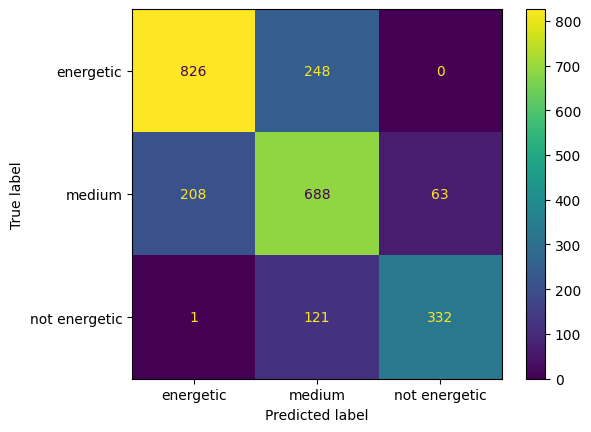

In [50]:
visualize_results(Y_test,models['Random forest'].predict(X_test))